# Handwritten digit classification using autoencoders

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [4]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets

print(torch.__version__)

1.5.0


In [5]:
# Downloading MNIST dataset
download = datasets.MNIST("./MNIST/", train=True, download=True)

In [6]:
# Path for storing data
Datapath = "MNIST/MNIST/raw/"

## Defining basic functions needed

In [7]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [8]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [9]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [10]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [11]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [12]:
print("Train images size : " + str(TrainImages.size()))
print("Train labels size : " + str(TrainImages.size()))
print("Test images size  : " + str(TrainImages.size()))
print("Test labels size  : " + str(TrainImages.size()))

Train images size : torch.Size([60000, 784])
Train labels size : torch.Size([60000, 784])
Test images size  : torch.Size([60000, 784])
Test labels size  : torch.Size([60000, 784])


In [13]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


## Defining the autoencoder

In [14]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100, 28*28), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


## Defining optimizer

In [40]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1.5, momentum=0.5)

## Training the autoencoder

In [41]:
iterations = 50
BatchSize = 10000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages, 0, torch.linspace(i*BatchSize, (i+1)*BatchSize-1, steps=BatchSize).long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print(" Iteration %3d/%3d, loss was %2.3f"%(epoch+1, iterations, runningLoss/(epoch+1)))
print("Finished training")

 Iteration   1/ 50, loss was 0.298
 Iteration   2/ 50, loss was 0.125
 Iteration   3/ 50, loss was 0.079
 Iteration   4/ 50, loss was 0.057
 Iteration   5/ 50, loss was 0.044
 Iteration   6/ 50, loss was 0.036
 Iteration   7/ 50, loss was 0.030
 Iteration   8/ 50, loss was 0.026
 Iteration   9/ 50, loss was 0.023
 Iteration  10/ 50, loss was 0.020
 Iteration  11/ 50, loss was 0.018
 Iteration  12/ 50, loss was 0.017
 Iteration  13/ 50, loss was 0.015
 Iteration  14/ 50, loss was 0.014
 Iteration  15/ 50, loss was 0.013
 Iteration  16/ 50, loss was 0.012
 Iteration  17/ 50, loss was 0.011
 Iteration  18/ 50, loss was 0.010
 Iteration  19/ 50, loss was 0.010
 Iteration  20/ 50, loss was 0.009
 Iteration  21/ 50, loss was 0.009
 Iteration  22/ 50, loss was 0.008
 Iteration  23/ 50, loss was 0.008
 Iteration  24/ 50, loss was 0.007
 Iteration  25/ 50, loss was 0.007
 Iteration  26/ 50, loss was 0.007
 Iteration  27/ 50, loss was 0.007
 Iteration  28/ 50, loss was 0.006
 Iteration  29/ 50, 

## Visualising result

[]

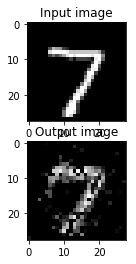

In [81]:
test_img = TestImages[0]

output_img = net((test_img.double().to(device))/255).data
output_img = (output_img*255).byte()
output_img = output_img.view(-1, 28, 28)

if device == "cuda":
    output_img = output_img.cpu()

test_img = test_img.view(-1, 28, 28)

plt.subplot(2,1,1)
img = np.array(test_img.numpy())[0]
plt.title("Input image")
plt.imshow(img, cmap="gray")

plt.subplot(2,1,2)
out_img = np.array(output_img.numpy())[0]
plt.title("Output image")
plt.imshow(out_img, cmap="gray")

plt.plot()

## Encoder weights visualisation

In [18]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

Text(0.5,1,'Updation of weights')

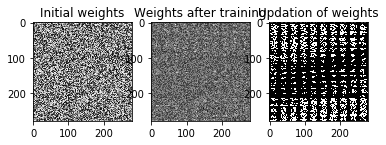

In [19]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

if use_gpu:
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = init_weights - trained_weights

plt.subplot(131)
plt.imshow(init_weights.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights.numpy()[0], cmap="gray")
plt.title("Updation of weights")

## Adding classification layer

In [74]:
classifier = nn.Sequential(*list(net.children())[:-1])
classifier_net = classifier
classifier_net.add_module("classifier", nn.Sequential(nn.Linear(100,10), nn.LogSoftmax(dim=1)))

# Locking the encoder layer (its values will not be changed during training)
lock = False
for i in list(classifier_net.children())[0][0].parameters():
    i.requires_grad = not lock

classifier_net.double().to(device)

init_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

## Defining optimizer again

In [75]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(classifier_net.parameters(), lr=0.01, momentum=0.9)

## Training the clasiffier

In [80]:
iterations = 30
batchsize = 50000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize).long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classifier_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
    inputs = TestImages.double()/255    
    inputs = inputs.to(device)
    outputs = classifier_net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if device == 'cuda':
        predicted = predicted.cpu()
        
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print(' Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.shape[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

 Iteration: 1 / 30  ;  Training Loss: 0.386981 ; Testing Acc: 89.669998 
 Iteration: 2 / 30  ;  Training Loss: 0.384267 ; Testing Acc: 89.750000 
 Iteration: 3 / 30  ;  Training Loss: 0.381680 ; Testing Acc: 89.820000 
 Iteration: 4 / 30  ;  Training Loss: 0.379212 ; Testing Acc: 89.860001 
 Iteration: 5 / 30  ;  Training Loss: 0.376851 ; Testing Acc: 89.940002 
 Iteration: 6 / 30  ;  Training Loss: 0.374588 ; Testing Acc: 89.989998 
 Iteration: 7 / 30  ;  Training Loss: 0.372418 ; Testing Acc: 90.050003 
 Iteration: 8 / 30  ;  Training Loss: 0.370333 ; Testing Acc: 90.099998 
 Iteration: 9 / 30  ;  Training Loss: 0.368326 ; Testing Acc: 90.160004 
 Iteration: 10 / 30  ;  Training Loss: 0.366392 ; Testing Acc: 90.209999 
 Iteration: 11 / 30  ;  Training Loss: 0.364526 ; Testing Acc: 90.209999 
 Iteration: 12 / 30  ;  Training Loss: 0.362724 ; Testing Acc: 90.220001 
 Iteration: 13 / 30  ;  Training Loss: 0.360983 ; Testing Acc: 90.269997 
 Iteration: 14 / 30  ;  Training Loss: 0.359298

## Encoder weights visualisation (again)

In [23]:
trained_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

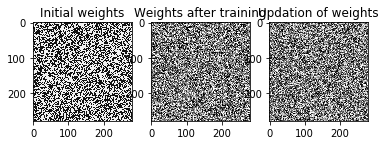

In [83]:
init_weights_2 = (1 + init_weights_2)*127.5
trained_weights_2 = (1 + trained_weights_2)*127.5

if use_gpu:
    init_weights_2 = init_weights_2.view(-1, 280, 280).byte().cpu()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte().cpu()
else:
    init_weights_2 = init_weights_2.view(-1,280,280).byte()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte()

d_weights_2 = init_weights_2 - trained_weights_2

plt.subplot(131)
plt.imshow(init_weights_2.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights_2.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights_2.numpy()[0], cmap="gray")
plt.title("Updation of weights")

plt.show()

## Output visualisation

Test set index no : 9423


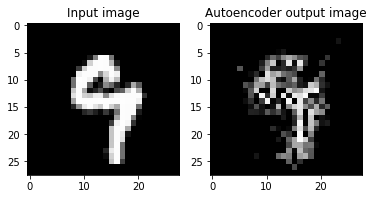

 Output of classifier : 9 
 Label : 9 

Test set index no : 8149


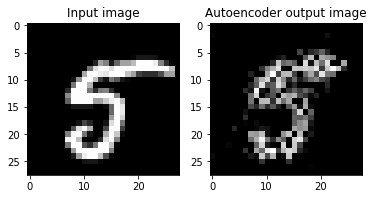

 Output of classifier : 5 
 Label : 5 

Test set index no : 7342


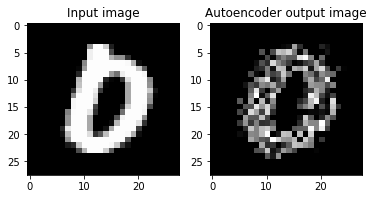

 Output of classifier : 0 
 Label : 0 

Test set index no : 5403


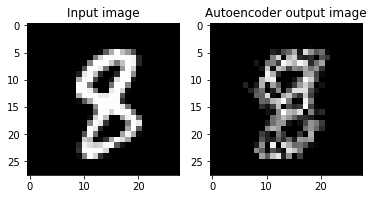

 Output of classifier : 8 
 Label : 8 

Test set index no : 3289


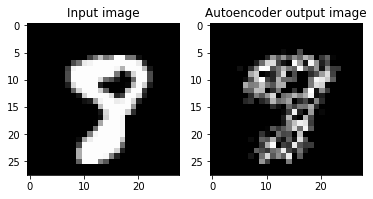

 Output of classifier : 7 
 Label : 8 

Test set index no : 2276


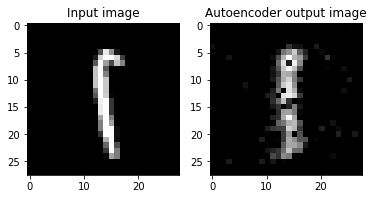

 Output of classifier : 1 
 Label : 1 

Test set index no : 1617


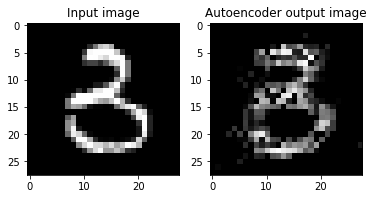

 Output of classifier : 3 
 Label : 3 

Test set index no : 4353


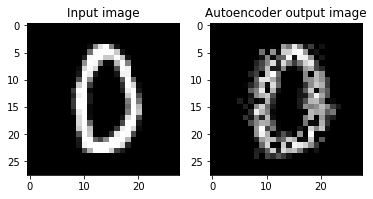

 Output of classifier : 0 
 Label : 0 

Test set index no : 8942


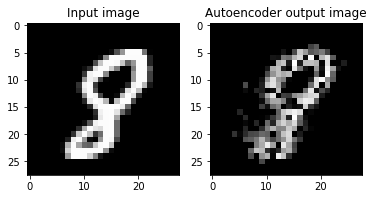

 Output of classifier : 8 
 Label : 8 

Test set index no : 4263


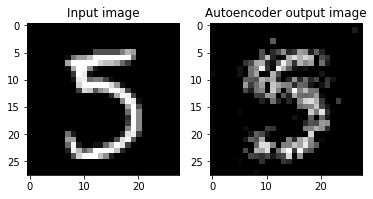

 Output of classifier : 3 
 Label : 5 



In [78]:
indices = np.random.uniform(0,TestImages.shape[0],size=10)

for index in indices:
    index = int(index)

    print("Test set index no : %d"%index)

    test_img = TestImages[index].reshape(1,784)

    output = classifier_net((test_img.double().to(device))/255)
    output_img = net((test_img.double().to(device))/255).data
    output_img = (output_img*255).byte()
    output_img = output_img.view(-1, 28, 28)
~
    if device == "cuda":
        output = output.cpu()
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Input image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    img = np.array(output_img.numpy())[0]
    plt.title("Autoencoder output image")
    plt.imshow(img, cmap="gray")
    plt.show()

    print(" Output of classifier : %d "%np.argmax(output.detach().numpy()))
    print(" Label : %d "%TestLabels[index])
    print()

In [47]:
print(classifier_net)

AttributeError: 'generator' object has no attribute 'requires_grad'